In [59]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [10]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [11]:
# Save references to each table
tbl_measurement = Base.classes['measurement']
tbl_station = Base.classes['station']

In [12]:
# creating inspectior for columns generation
inspector = inspect(engine)
# Printing table metadata
for table in tables:
    print("\n")
    print('-' * 12)
    print(f"table '{table}' has the following columns:")
    print('-' * 12)
    for column in inspector.get_columns(table):
        print(f"name: {column['name']}   column type: {column['type']}")



------------
table 'measurement' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: date   column type: TEXT
name: prcp   column type: FLOAT
name: tobs   column type: FLOAT


------------
table 'station' has the following columns:
------------
name: id   column type: INTEGER
name: station   column type: TEXT
name: name   column type: TEXT
name: latitude   column type: FLOAT
name: longitude   column type: FLOAT
name: elevation   column type: FLOAT


In [13]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [14]:
# idea base from: https://riptutorial.com/sqlalchemy/example/6614/converting-a-query-result-to-dict
def object_as_dict(obj):
    """
    This function takes in a Class instance and converts it to a dictionary
    """
    obj_count = 1
    try:
        obj_count = len(obj)
    except:
        pass
    if  obj_count == 1:
        base_dict = {c.key: getattr(obj, c.key)
            for c in inspect(obj).mapper.column_attrs}
        return base_dict
    else:
        cur_obj = obj[0]
        base_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
        for i in range(1, obj_count):
            cur_obj = obj[i]
            cur_dict = {c.key: getattr(cur_obj, c.key) for c in inspect(cur_obj).mapper.column_attrs}
            base_dict = {**base_dict, **cur_dict} 
        return base_dict  

In [15]:
# from jeff LOL
def query_to_list_of_dicts(cur_query):
    """
    From a query object return a list of dictionaries
    """
    return [object_as_dict(row) for row in cur_query]

In [16]:
#Define function to substract # of months from date
def month_offset(no_months, _self=dt.date.today()):
    """
    Returns the datetime (today by default) plus or minus the number of months.
    Needs pandas & datetime library
    """
    _self=pd.to_datetime(_self)
    current_month = _self.month
    current_year = _self.year
    total_months = current_month+current_year*12
    final_year = (total_months+no_months) // 12
    final_month = (total_months+no_months) % 12
    _self=_self.replace(year=final_year,month=final_month)
    return dt.date.strftime(_self, '%Y-%m-%d')


#test
month_offset(-12)

'2019-04-09'

In [17]:
help(plt.legend)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the axes.
    
    Call signatures::
    
        legend()
        legend(labels)
        legend(handles, labels)
    
    The call signatures correspond to three different ways how to use
    this method.
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        line, = ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    Specific lines can be excluded from the automatic legend element
    selection by defining a label st

[]

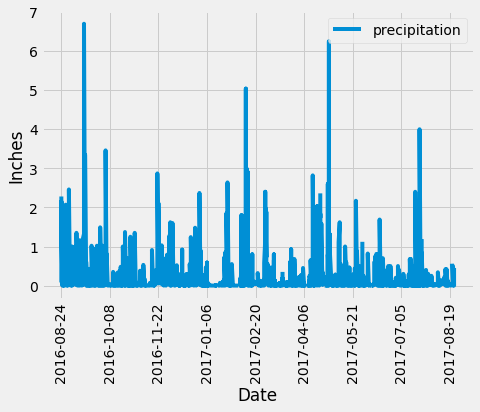

In [76]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_date_recorded = session.query(func.max(tbl_measurement.date)).first()[0]
starting_date_for_analysis = month_offset(-12, last_date_recorded)

# Perform a query to retrieve the data and precipitation scores
qry_measurements_last_year_records = session.query(tbl_measurement)\
    .filter(tbl_measurement.date > starting_date_for_analysis)\
    .order_by(tbl_measurement.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
df_measurements_last_year_records = \
    pd.read_sql_query(qry_measurements_last_year_records.statement, session.bind)

# Use Pandas Plotting with Matplotlib to plot the data
x_axis=df_measurements_last_year_records.loc[:,"date"]
y_axis=df_measurements_last_year_records.loc[:,"prcp"]

#D
fig = plt.figure()
axis = fig.add_axes([0, 0, 1, 1])
axis.plot(x_axis, y_axis)
axis.set_xlabel("Date")
axis.set_ylabel("Inches")
axis.legend(["precipitation"], loc="upper right")

#Spacing between each grid line
loc = plticker.MultipleLocator(base=45)
axis.xaxis.set_major_locator(loc)
#rotate ticks
axis.tick_params(axis="x", labelrotation=90, which='major')

plt.plot()


In [ ]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [ ]:
# Design a query to show how many stations are available in this dataset?


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
